# Demonstrate result using pretrained model

## Load model

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2

load_model = torch.load('model.pt', map_location=torch.device('cpu'))
load_model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

## Visualize result

In [35]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Tail'}

def visualize_result(image, bboxes, keypoints):
    # Draw rectangle for each bounding box
    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    # Draw circle for each keypoint and write corresponding class
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), -5)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

    plt.figure(figsize=(40,40))
    plt.axis('off')
    plt.imshow(image)

## Open image and run model

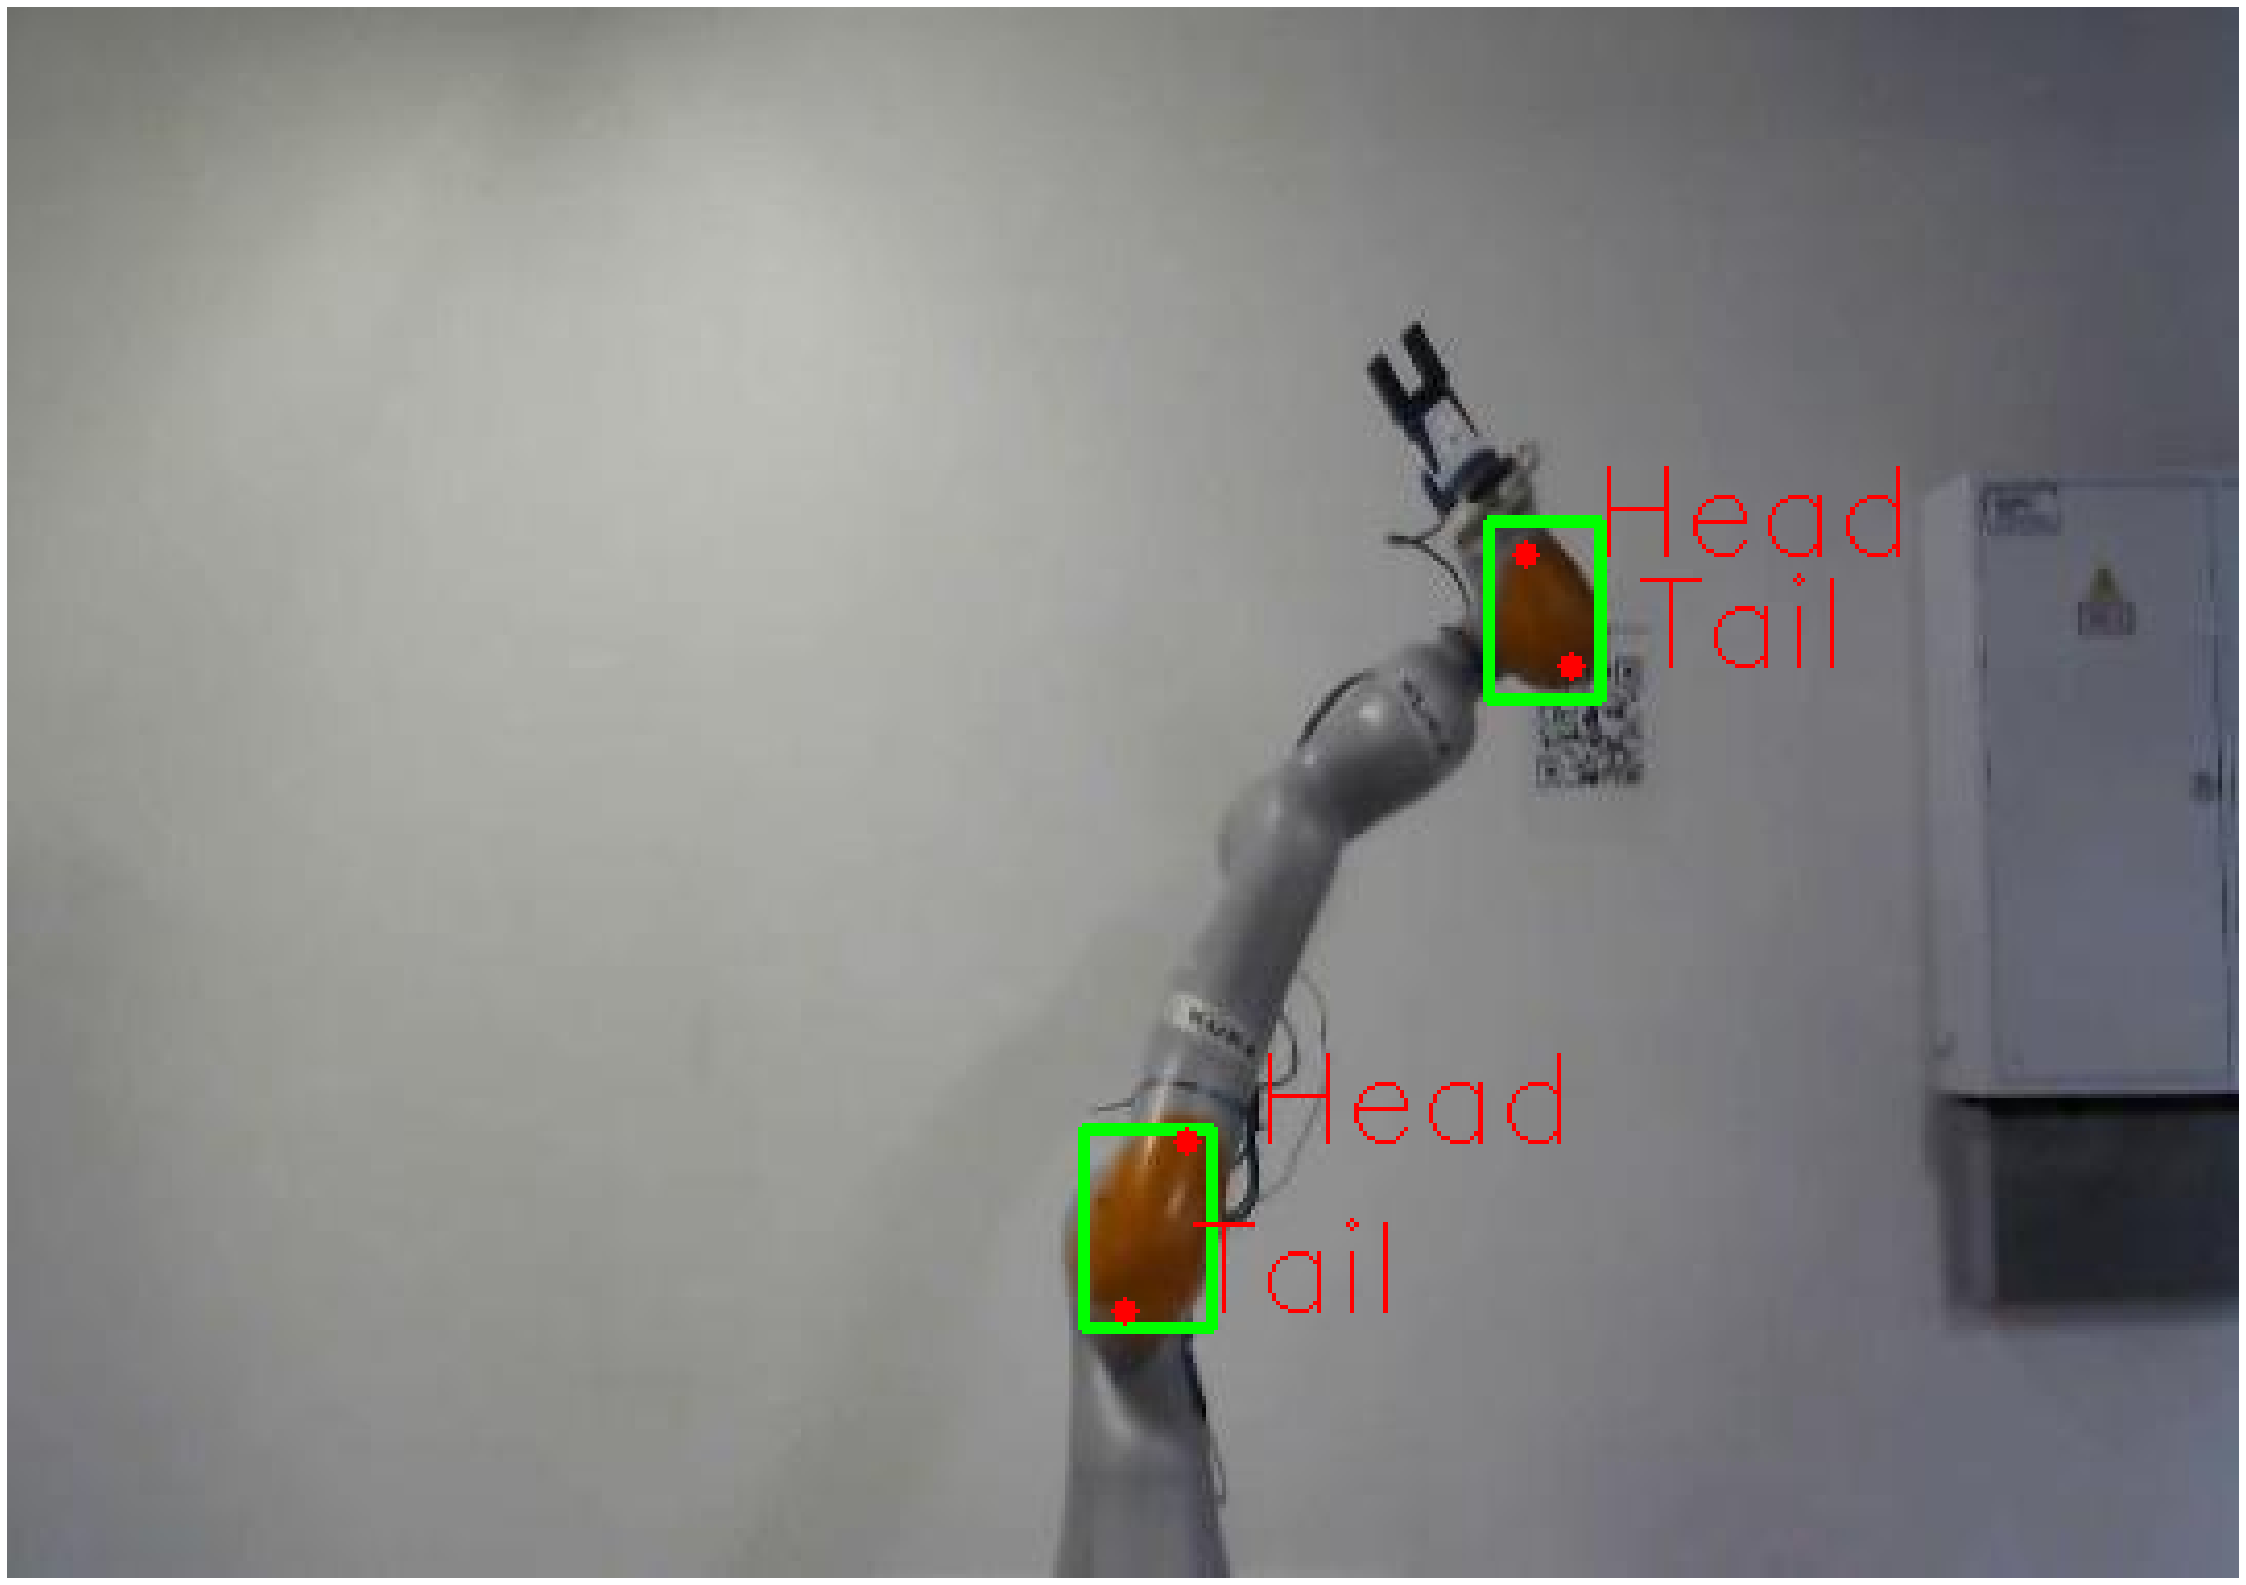

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

image = cv2.imread('/images/test/images/frame111_jpg.rf.aac5c9efea1250bf86c8121a62614a48.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = [torch.Tensor(image / 255).permute(2,0,1)]

with torch.no_grad():
    load_model.to(device)
    load_model.eval()
    output = load_model(image)

image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
# Get prediction scores
scores = output[0]['scores'].detach().cpu().numpy()

# Find indices of elements with score > 0.2
high_scores_idxs = np.where(scores > 0.2)[0].tolist()
# Find indicess of boxes after applying Non-Maximum Suppression (NMS)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.1).cpu().numpy()

# Find bounding boxes using thresholed indices
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

# Find keypoints using thresholed indices
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

visualize_result(image, bboxes, keypoints)